Lately I've seen the info that Logistic Regression and Random Forest are the most used ML algos in business, let's see which one of 'em is better in tellin' us whether an employee will leave the company. The dataset is very nice, no missing values, just needs some encoding.

I will not repeat myself in the code, will use "inplace=True" and will come back to previous cells when necessary.

Comments are under the cells.

In [19]:
import numpy             as np
import pandas            as pd
import matplotlib        as mpl
import matplotlib.pyplot as plt
import seaborn           as sns

In [20]:
data = pd.read_csv('HR_comma_sep.csv')

# Data Engineering

In [21]:
data.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   sales                  14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [23]:
data.rename(columns = {'sales':'dep'}, inplace = True)
ohe_dep = pd.get_dummies(data['dep'])
data    = pd.concat([data, ohe_dep], axis=1)
data    . drop(labels=['dep'],axis=1, inplace=True)

ohe_salary  = pd.get_dummies(data['salary'])
data        = pd.concat([data, ohe_salary], axis=1)
data        . drop(labels=['salary'],axis=1, inplace=True)

I prefer usual encoding, but unfortunately some models prefer scaled values, so one-hots are necessary.

In [24]:
data.isnull().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
IT                       0
RandD                    0
accounting               0
hr                       0
management               0
marketing                0
product_mng              0
sales                    0
support                  0
technical                0
high                     0
low                      0
medium                   0
dtype: int64

As i promised, no missing values

Text(0.5, 1.0, 'Correlation between different fearures')

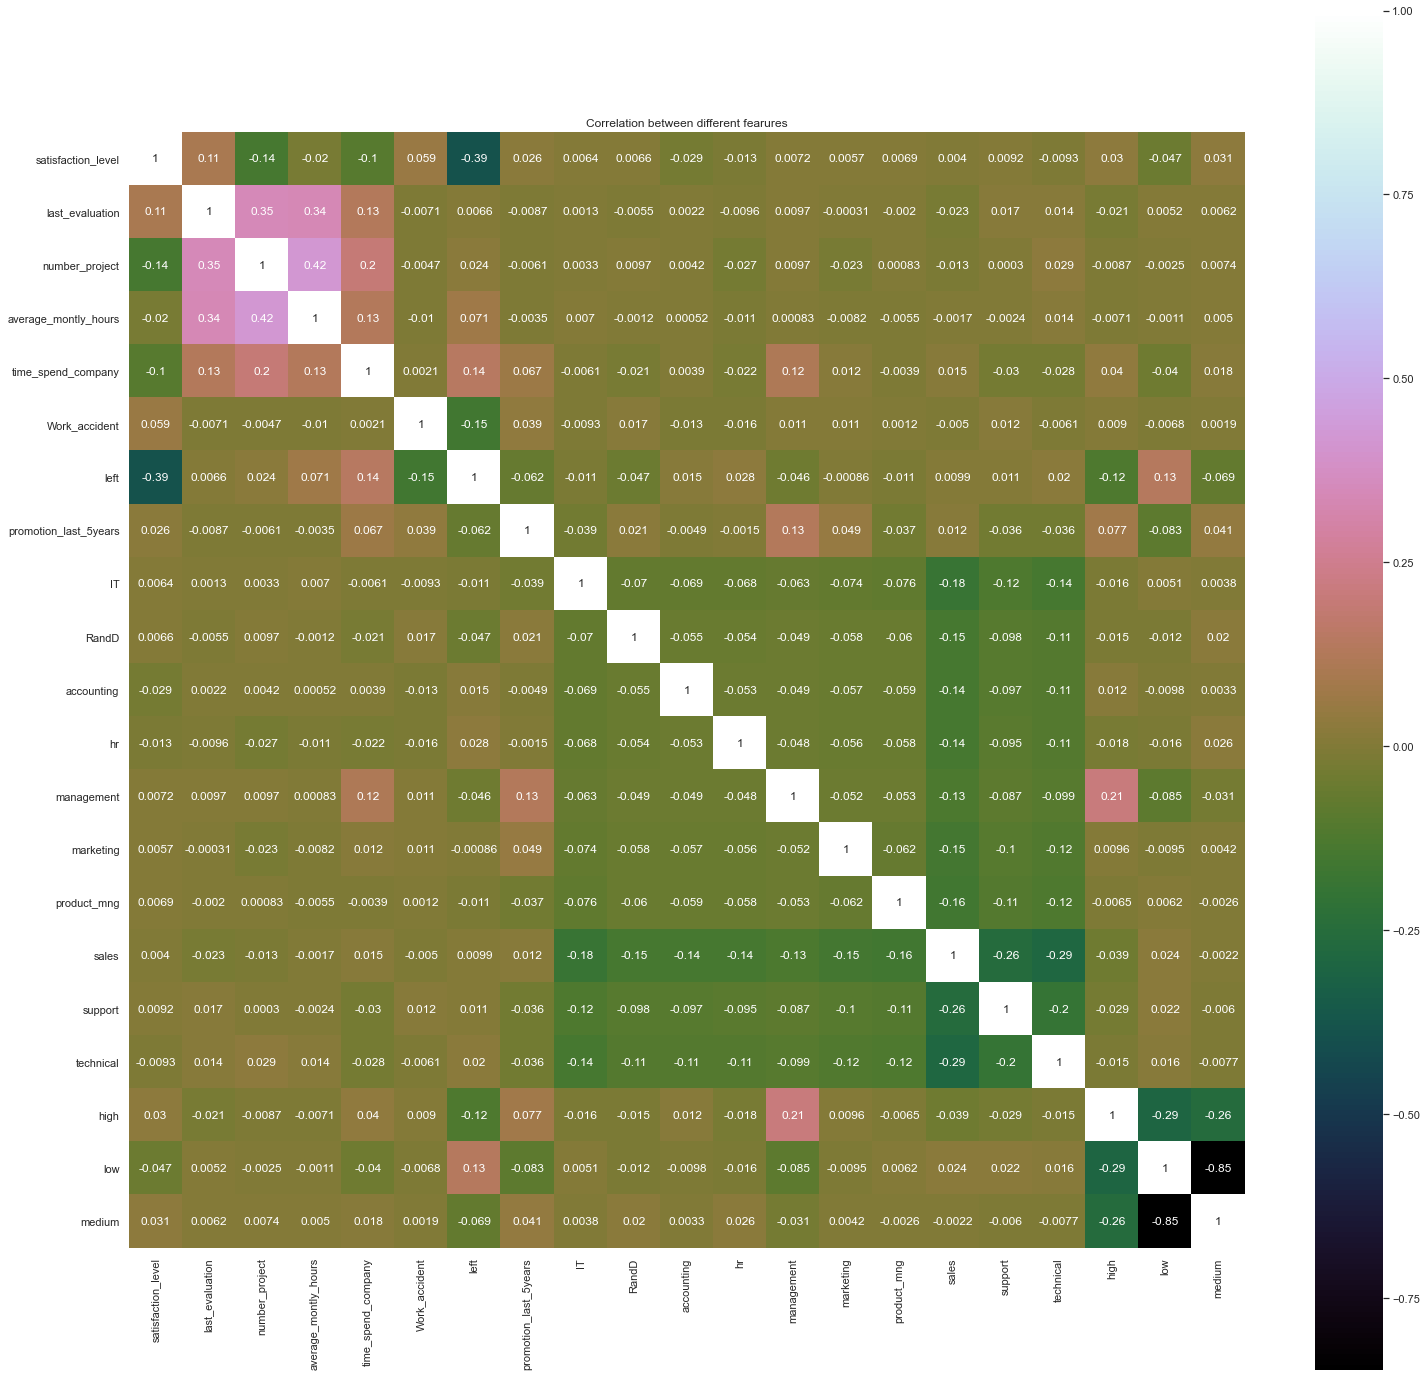

In [7]:
sns.set(font_scale=1)
plt.figure(figsize=(25,25))
sns.heatmap(data.corr(), vmax=1, square=True,annot=True,cmap='cubehelix')

plt.title('Correlation between different fearures')

No correaltions above 0.5, PCA probably won't work...

In [12]:
X = data.drop(labels=['left'],axis=1)
y = data['left']

from sklearn.model_selection import train_test_split
X_train, X_test,y_train, y_test = train_test_split(X, y, train_size = 0.8, test_size = 0.2, random_state = 100)

In [13]:
from sklearn.preprocessing import StandardScaler
X_train_std = StandardScaler().fit_transform(X_train)
X_test_std  = StandardScaler().fit_transform(X_test)

Scaled version of dataset for Logistic Regression. Just in case anyone anyone will read it, don't normalize/standartizise before splitting your data set. Do it after, just like I did, otherwise you'll get a data leak (google it).

# Log Reg

In [14]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model . fit(X_train_std, y_train)
print(model, '\n')
print('Training set score: ',model.score(X_train_std, y_train))
print('Test set score    : ',model.score(X_test_std, y_test))

LogisticRegression() 

Training set score:  0.7872322693557796
Test set score    :  0.781


In [15]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model      import LogisticRegression
model = RFECV(estimator=LogisticRegression(), step=1, cv=10, scoring='accuracy')
model . fit(X_train_std, y_train)
print(model, '\n')
print('Training set score: ',model.score(X_train_std, y_train))
print('Test set score    : ',model.score(X_test_std, y_test))

RFECV(cv=10, estimator=LogisticRegression(), scoring='accuracy') 

Training set score:  0.7956496374697891
Test set score    :  0.7893333333333333


In [16]:
from sklearn.decomposition import PCA
from sklearn.linear_model  import LogisticRegression
pca = PCA(n_components=20)
pca . fit(X_train_std)

X_train_std_pca = pca.transform(X_train_std)
X_test_std_pca  = pca.transform(X_test_std)

model = LogisticRegression()
model . fit(X_train_std_pca, y_train)
print(model, '\n')
print('Training set score: ',model.score(X_train_std_pca, y_train))
print('Test set score    : ',model.score(X_test_std_pca, y_test))

LogisticRegression() 

Training set score:  0.7872322693557796
Test set score    :  0.781


The best we can get from Log Reg is using RFE cross validation. All right..

# Forest

In [17]:
from sklearn import tree
model = tree.DecisionTreeClassifier(min_samples_split=25)
model . fit(X_train, y_train)
print(model, '\n')
print('Training set score: ',model.score(X_train, y_train))
print('Test set score    : ',model.score(X_test, y_test))

DecisionTreeClassifier(min_samples_split=25) 

Training set score:  0.9820818401533461
Test set score    :  0.9766666666666667


That's better!

In [28]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators = 96, max_depth=37)
model . fit(X_train, y_train)
print(model, '\n')
print('Training set score: ',model.score(X_train, y_train))
print('Test set score    : ',model.score(X_test, y_test))

RandomForestClassifier(max_depth=37, n_estimators=96) 

Training set score:  1.0
Test set score    :  0.9936666666666667


Yessir, let's try to optimize a bit.

Text(0, 0.5, 'Accuracy')

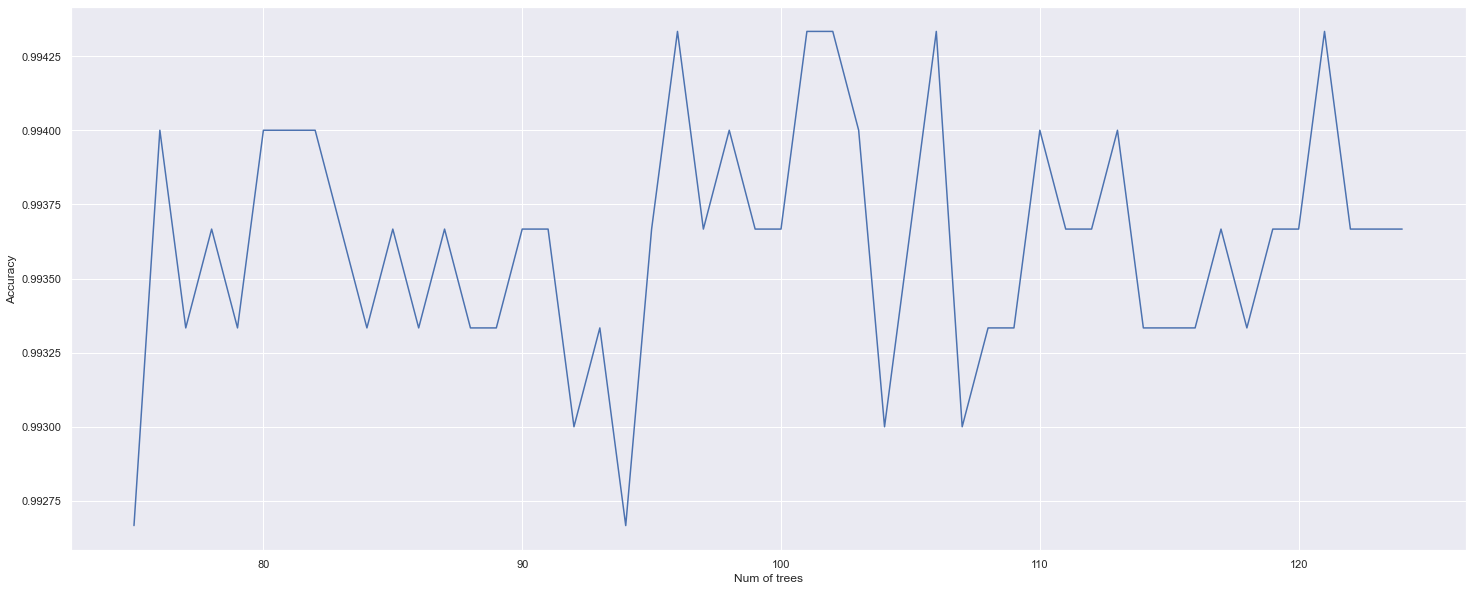

In [455]:
p      = range(75,125)
scores = []

for i in p:
    clf_rf = RandomForestClassifier(n_estimators = i)
    clf_rf.fit(X_train,y_train)
    y_pred = clf_rf.predict(X_test)
    scores.append(accuracy_score(y_test,y_pred))

plt.figure(figsize=(25,10))
plt.plot  (p,scores)
plt.xlabel('Num of trees')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Accuracy')

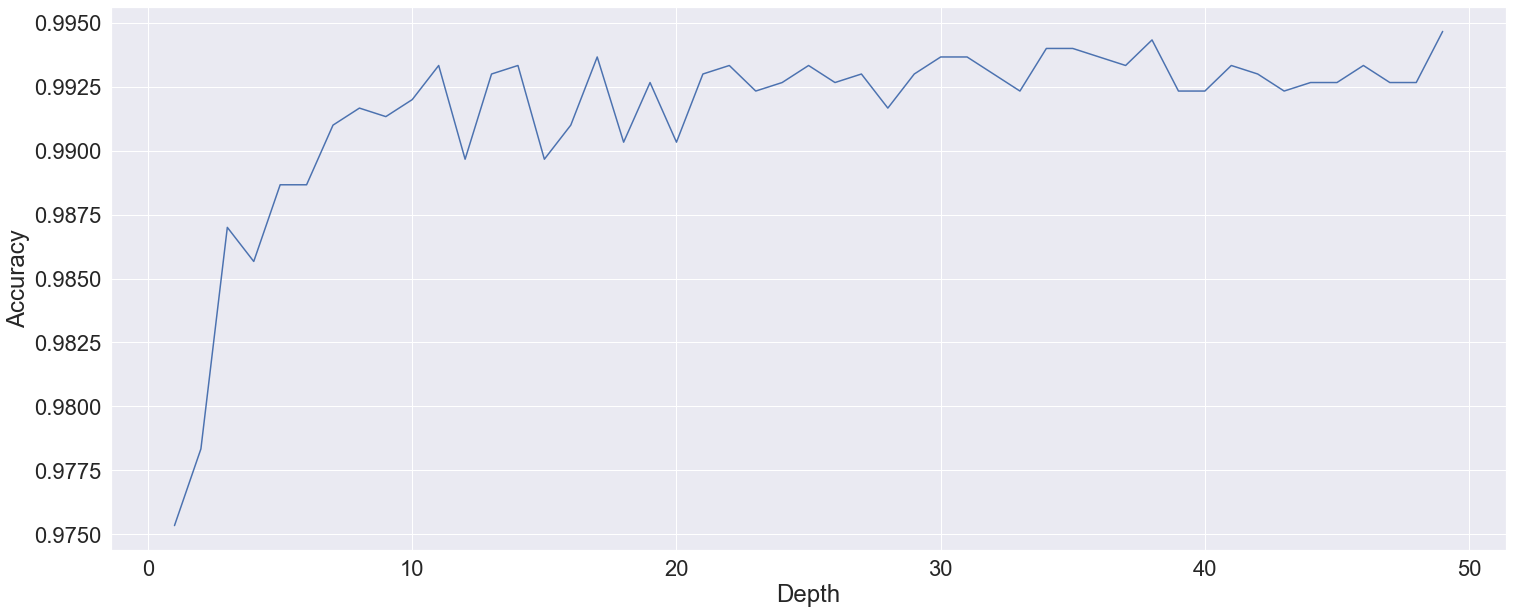

In [321]:
p      = range(1,50)
scores = []

for i in p:
    clf_rf = RandomForestClassifier(n_estimators = i)
    clf_rf.fit(X_train,y_train)
    y_pred = clf_rf.predict(X_test)
    scores.append(accuracy_score(y_test,y_pred))

plt.figure(figsize=(25,10))
plt.plot  (p,scores)
plt.xlabel('Depth')
plt.ylabel('Accuracy')

After the optimization, 96 trees with depth of 37 levels were chosen.
Training accuracy is 1.0 and test accuracy is 0.9936666666666667, over & underfittinf are out of the question considering.
The model works and ready for live!